# Exercício: análise de sentimento em reviews

**Objetivo:** predizer o sentimento (positivo / negativo) de um review textual

## O que é NLP?

NLP (ou _Natural Language Processing_ - a sigla em português é PLN, _Processamento de Linguagem Natural_, mas essa sigla também é usada para falar de _Programação Neurolinguística_, então, vamos continuar usando NLP, ok?) é a área relacionada a técnicas para o entendimento de linguagem humana (a linguagem natural). A aplicação de técnicas de NLP tem sido vista em muitos domínios, desde a correção de palavras e sugestão de palavras na barra de busca de sites como o _Google_, até em sistemas mais "sofisticados" como os tradutores automáticos e os _home assistant_ e _smart assistants_, como Siri, Alexa ou Google Home, que podem auxiliar na execução de certas tarefas, como agendar compromissos, embora eles ainda [estejam longe de ser à prova de erros](https://www.nytimes.com/2018/05/25/business/amazon-alexa-conversation-shared-echo.html). Com o crescimento de conteúdo (mais artigos e mais fontes espalhadas), a importância do NLP também tem crescido, pois tarefas como sumarização automática e classificação automática de conteúdo (por ex., para checagem contra _fake news_) são cada vez mais necessárias em nossas vidas.

Neste exercício, vamos focar no uso de algumas técnicas de NLP para processamento de texto. Entretanto, é importante lembrar que NLP não se restringe a textos escritos, podendo ser aplicado também para processamento de fala, como é o caso dos _smart assistants_.

Diferentes tarefas de NLP, em geral, têm como passos iniciais as seguintes etapas:

* pré-processamento do texto (que pode ser uma combinação de diferentes processamentos, envolvendo modificações a nível de palavra e identificação de entidades/funções sintáticas/etc.)

* transformação do texto em quantidades numéricas (tipicamente vetores de números inteiros ou reais)

In [ ]:
# ! pip install matplotlib nltk pandas seaborn scikit-learn

In [2]:
import pandas as pd

## bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Leitura de dados

Esse conjunto de dados é composto de reviews de produtos coletados do site `Americanas.com` entre janeiro e maio de 2018.

Mais informações podem ser encontradas no [repositório b2w-reviews01](https://github.com/b2wdigital/b2w-reviews01).

In [4]:
selected_cols = ['product_name', 'product_brand', 'site_category_lv1', 'site_category_lv2',
                 'review_title', 'review_text', 'recommend_to_a_friend']

path = 'data/datasets'
reviews_df = pd.read_csv('https://github.com/b2wdigital/b2w-reviews01/raw/master/B2W-Reviews01.csv', sep=';', low_memory=False)[selected_cols].fillna('')

In [5]:
reviews_df.head()

,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,review_text,recommend_to_a_friend
0,Notebook Asus Vivobook Max X541NA-GO472T Intel...,,Informática,Notebook,Bom,Estou contente com a compra entrega rápida o ú...,Yes
1,Copo Acrílico Com Canudo 500ml Rocie,,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade","Por apenas R$1994.20,eu consegui comprar esse ...",Yes
2,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,Yes
3,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,Yes
4,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente","A entrega foi no prazo, as americanas estão de...",Yes


## Criação de novas colunas

* `text`: coluna que contém o review completo (título + corpo)

In [6]:
reviews_df['text'] = reviews_df['review_title'] + ' ' + reviews_df['review_text']

In [7]:
reviews_df.iloc[0]['text']

'Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.'

* Cheque se não há nada com texto vazio

In [8]:
reviews_df[reviews_df['text'].str.len() == 0]

,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,review_text,recommend_to_a_friend,text


### Formato da coluna target

A coluna `target` é a polaridade / o sentimento do review. Para calculá-lo, vamos considerar a coluna `recommend_to_a_friend` e transformá-la de forma que:
* se `recommend_to_a_friend` = `Yes`, então, `target` = 1
* se `recommend_to_a_friend` = `No`, então, `target` = 0

In [9]:
reviews_df['target'] = (reviews_df['recommend_to_a_friend'] == 'Yes').astype(int)

### Novas colunas

Como podemos ver, agora temos o texto do review e a polaridade da sentença. 

In [10]:
reviews_df[['text', 'target']].head()

,text,target
0,Bom Estou contente com a compra entrega rápida...,1
1,"Preço imbatível, ótima qualidade Por apenas R$...",1
2,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...,1
3,presente mais que desejado MEU FILHO AMOU! PAR...,1
4,"Sem duvidas, excelente A entrega foi no prazo,...",1


## Inspeção de algumas colunas

### Coluna `target`

In [11]:
reviews_df[['target']].value_counts()

target
1         96368
0         36005
dtype: int64

### Coluna `text`

* distribuição de número de caracteres
* inspeção visual do texto

In [12]:
reviews_df['text_nchars'] = reviews_df['text'].str.len()

In [13]:
reviews_df[['text_nchars']].describe()

,text_nchars
count,132373.000000
mean,161.587076
std,140.354253
min,52.000000
25%,85.000000
50%,117.000000
75%,183.000000
max,4585.000000


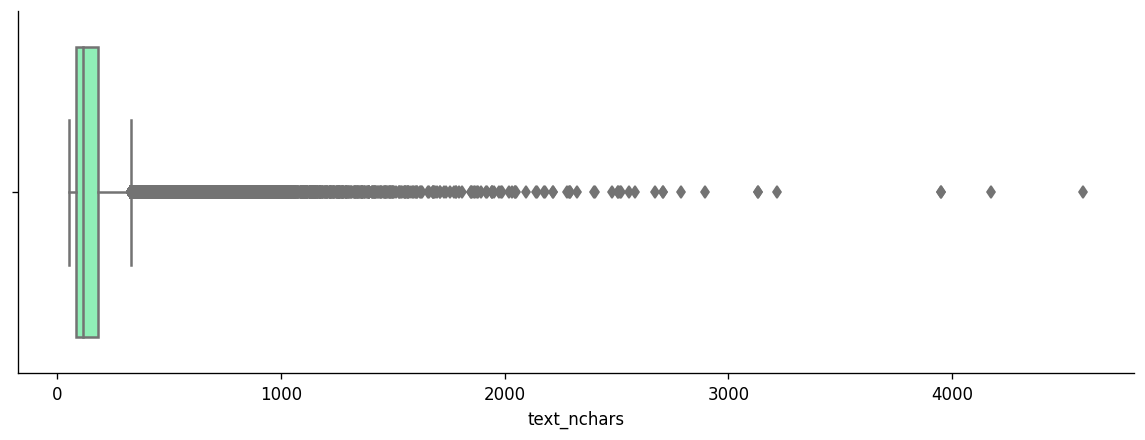

In [14]:
fig = plt.figure(figsize=(12, 4), dpi=120)
ax = fig.add_subplot(111)
sns.boxplot(x="text_nchars", data=reviews_df, palette="rainbow", ax=ax)
sns.despine()

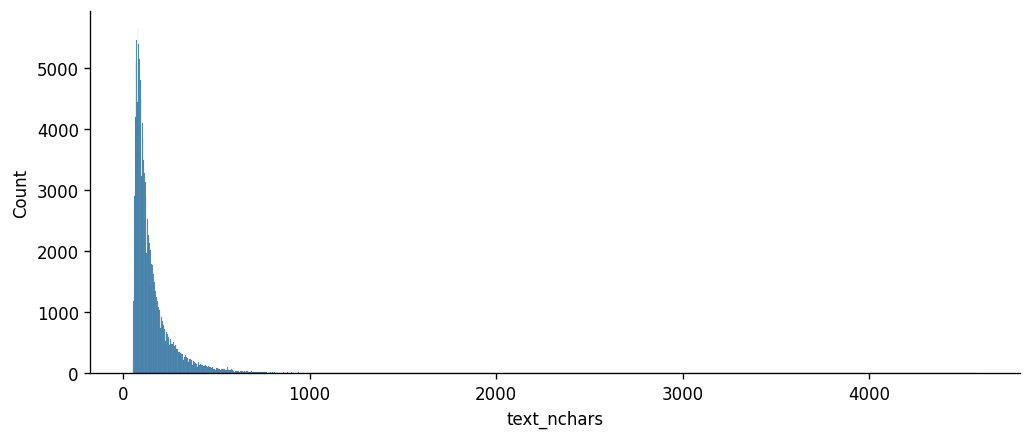

In [15]:
fig = plt.figure(figsize=(10, 4), dpi=120)
ax = fig.add_subplot(111)
sns.histplot(x="text_nchars", data=reviews_df, palette="rainbow", ax=ax)
sns.despine()

Nosso objetivo é construir um **classificador de sentimentos**, que recebe uma sentença (referente a um review de produto) e é capaz de predizer se o review é positivo (o usuário recomendaria a um amigo) ou negativo (o usuário **não** recomendaria a um amigo).

In [16]:
reviews_df.sample(n=10)['text'].tolist()

['Ótimo produto Excelente produto, muito bem embalado e entregue antes do prazo estipulado. Americanas sempre surpreendendo positivamente no e-commerce.',
 'Empresa enganosa Quando comprei falava 20 dias úteis para entrega, hj 10/04 já fazem quase um mês que está aguardando nota fiscal e a empresa não dá um respaldo.',
 'nota 10 conforme anunciado Top, entrega super rápida, produto de qualidade!!!!!!!!!!!!!!!!',
 'pessimo produto me arrependi de ter comprado este cubo para dar de presente ao meu sobrinho... Na primeira brincada já desmontou tudo.... Não comprem, que é roubada!!!',
 'Produto chegou quebrado Não utilizei o produto pois ele chegou quebrado. A americanas autorizou uma troca, no entanto, até este momento, a transportadora ainda nao coletou o produto quebrado e eu estou sem utilizar o item adquirido.',
 'Bom produto Na primeira vez o produto veio com defeito. Acho que me mandaram o mesmo de volta, mas consertado. Ainda estou cismado se não vai apresentar problemas depois, po

**Nos exemplos de frases acima, podemos ver que as sentenças incluem pontuações, acentos, letras maiúsculas e minúsculas... Seria ideal que conseguíssemos _normalizar_ o texto, de forma a diminuir a quantidade de palavras diferentes.**

## Normalização do texto

Técnicas comuns:

* remoção de acentos

* remoção de palavras muito comuns (_stopwords_)

* remoção de pontuação

* remoção de dígitos

* padronização para letras minúsculas (ou maiúsculas)

* _stemming_ / _lematização_ - redução de palavras relacionadas a uma forma mínima comum (ex. `construirá -> construir`, `construção -> construir`)

* correção de palavras escritas incorretamente (uso de spellchecker)

**Leia mais:**

* sobre a diferença entre stemming e lematização em [uma discussão no StackOverflow](https://stackoverflow.com/questions/1787110/what-is-the-true-difference-between-lemmatization-vs-stemming);

* sobre a situação atual em relação à lematização para a língua portuguesa nesse [blog post](https://lars76.github.io/nlp/lemmatize-portuguese/).

**Atenção:** todas essas técnicas envolvem operações com `strings`. Como estamos trabalhando com um dataframe Pandas, quando possível, vamos usar os métodos descritos [na documentação do Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html).

#### Remoção de acentos

In [17]:
reviews_df['norm_text'] = reviews_df['text'].str.normalize('NFKD').str.encode('ascii', 'ignore').str.decode('utf-8')

Forma alternativa:

>```python
> from unicodedata import normalize
>
> def remove_accents(text):
    return normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
>
> reviews_df['norm_text'] = reviews_df['text'].apply(normalize_text)
>```

In [18]:
reviews_df[['text', 'norm_text']].head()

,text,norm_text
0,Bom Estou contente com a compra entrega rápida...,Bom Estou contente com a compra entrega rapida...
1,"Preço imbatível, ótima qualidade Por apenas R$...","Preco imbativel, otima qualidade Por apenas R$..."
2,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...
3,presente mais que desejado MEU FILHO AMOU! PAR...,presente mais que desejado MEU FILHO AMOU! PAR...
4,"Sem duvidas, excelente A entrega foi no prazo,...","Sem duvidas, excelente A entrega foi no prazo,..."


#### Padronização para letras minúsculas

In [19]:
reviews_df['norm_text'] = reviews_df['norm_text'].str.lower()

In [20]:
reviews_df[['text', 'norm_text']].head()

,text,norm_text
0,Bom Estou contente com a compra entrega rápida...,bom estou contente com a compra entrega rapida...
1,"Preço imbatível, ótima qualidade Por apenas R$...","preco imbativel, otima qualidade por apenas r$..."
2,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...,atende todas as expectativa. supera em agilida...
3,presente mais que desejado MEU FILHO AMOU! PAR...,presente mais que desejado meu filho amou! par...
4,"Sem duvidas, excelente A entrega foi no prazo,...","sem duvidas, excelente a entrega foi no prazo,..."


#### Remoção de dígitos

Aqui, para facilitar, vamos usar as chamadas [expressões regulares](https://docs.python.org/pt-br/3.8/howto/regex.html).

Para mais informações, você pode consultar essa [página](https://kmee.github.io/treinamento-python/google/regular-expressions.html).

In [21]:
reviews_df['norm_text'] = reviews_df['norm_text'].str.replace(r'[0-9]', '')

Forma alternativa **sem** usar expressões regulares:

> ```python
> for digit in range(10):
    reviews_df['norm_text'] = reviews_df['norm_text'].str.replace(str(digit), '')
> ``` 

Forma alternativa usando expressões regulares, explicitamente usando a biblioteca [re](https://docs.python.org/3.6/library/re.html):

> ```python
> import re
>
> def replace_digits(text):
    return re.sub(r'\d', '', text)
> 
> reviews_df['norm_text'] = reviews_df['norm_text'].apply(replace_digits)
> ```

In [22]:
reviews_df[reviews_df['text'].str.contains('0')][['text', 'norm_text']].head()

,text,norm_text
1,"Preço imbatível, ótima qualidade Por apenas R$...","preco imbativel, otima qualidade por apenas r$..."
2,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...,atende todas as expectativa. supera em agilida...
21,TV Espetacular Pontos Positivos Painel de 10bi...,tv espetacular pontos positivos painel de bits...
68,"7 Muito bom veio no esperado,Não pensei que vi...","muito bom veio no esperado,nao pensei que vin..."
69,Ainda não recebi Comprei o produto dia 30/11 a...,ainda nao recebi comprei o produto dia / ate h...


#### Remoção de pontuação

Para remover a pontuação, podemos usar o próprio módulo `string` do python, que já tem mapeadas as pontuações de texto possíveis.

In [23]:
import string

translation_table = str.maketrans({key: ' ' for key in string.punctuation}) 

def remove_punctuation(text):
    return text.translate(translation_table)

* vamos testar a função?

In [24]:
print('Quando ela olhou, gritei bem alto: \n - "Não me engana, não, hein?!"')

Quando ela olhou, gritei bem alto: 
 - "Não me engana, não, hein?!"


In [25]:
remove_punctuation('Quando ela olhou, gritei bem alto: \n - "Não me engana, não, hein?!"')

'Quando ela olhou  gritei bem alto  \n    Não me engana  não  hein   '

In [26]:
reviews_df['norm_text'] = reviews_df['norm_text'].apply(remove_punctuation)

In [27]:
reviews_df[reviews_df['text'].str.contains('!')][['text', 'norm_text']].head()

,text,norm_text
3,presente mais que desejado MEU FILHO AMOU! PAR...,presente mais que desejado meu filho amou par...
10,Fantástico Comprei um pra cara membro da famíl...,fantastico comprei um pra cara membro da famil...
11,Maravilhoso!!! Produto maravilhoso! Não é baru...,maravilhoso produto maravilhoso nao e baru...
19,Vou usa-la A capa não decepcionou por enquanto...,vou usa la a capa nao decepcionou por enquanto...
21,TV Espetacular Pontos Positivos Painel de 10bi...,tv espetacular pontos positivos painel de bits...


#### Remoção de stopwords

In [28]:
import nltk

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cinthia.tanaka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
' / '.join(nltk.corpus.stopwords.words('portuguese'))

'de / a / o / que / e / é / do / da / em / um / para / com / não / uma / os / no / se / na / por / mais / as / dos / como / mas / ao / ele / das / à / seu / sua / ou / quando / muito / nos / já / eu / também / só / pelo / pela / até / isso / ela / entre / depois / sem / mesmo / aos / seus / quem / nas / me / esse / eles / você / essa / num / nem / suas / meu / às / minha / numa / pelos / elas / qual / nós / lhe / deles / essas / esses / pelas / este / dele / tu / te / vocês / vos / lhes / meus / minhas / teu / tua / teus / tuas / nosso / nossa / nossos / nossas / dela / delas / esta / estes / estas / aquele / aquela / aqueles / aquelas / isto / aquilo / estou / está / estamos / estão / estive / esteve / estivemos / estiveram / estava / estávamos / estavam / estivera / estivéramos / esteja / estejamos / estejam / estivesse / estivéssemos / estivessem / estiver / estivermos / estiverem / hei / há / havemos / hão / houve / houvemos / houveram / houvera / houvéramos / haja / hajamos / haja

**_Ponto importante_:** Como nossa tarefa é uma análise de sentimentos, seria muito ruim perder certas _stopwords_ como palavras de negação, afinal, "Eu **não** gosto disso"  é muito diferente de "Eu gosto disso"!

Assim, vamos manter algumas das palavras que podem ser essenciais para a classificação:

* `não`

* `mas`

Ou seja, gostaríamos de remover as palavras `não` e `mas` da lista de stopwords fornecida pelo `nltk`. Além disso, note que essa lista contém acentos. Vamos retirá-los.

In [31]:
from unicodedata import normalize

def remove_accents(text):
    return normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

**Tarefa:** 

Crie uma lista chamada `stopwords` que contém todas as palavras de `nltk.corpus.stopwords.words('portuguese')`, exceto as palavras `não` e `mas`. A cada palavra deve ser aplicada a função `normalize_text`.

1. defina uma lista chamada `not_allowed` com as palavras "não" e "mas".
2. crie uma lista vazia chamada stopwords
3. faça um loop para percorrer cada uma das palavras de `nltk.corpus.stopwords.words('portuguese')`
    * a cada loop, você deve checar se a palavra atual está contida dentro de `not_allowed`
    * se **não** estiver, você deve incluir a palavra à lista de stopwords

<!-- 
not_allowed = ["não", "mas"]
stopwords = []
for word in nltk.corpus.stopwords.words('portuguese'):
    if word not in not_allowed:
        stopwords.append(remove_accents(word))
-->

In [32]:
not_allowed = ["não", "mas"]
stopwords = []
for word in nltk.corpus.stopwords.words('portuguese'):
    if word not in not_allowed:
        stopwords.append(remove_accents(word))

In [33]:
' / '.join(stopwords)

'de / a / o / que / e / e / do / da / em / um / para / com / uma / os / no / se / na / por / mais / as / dos / como / ao / ele / das / a / seu / sua / ou / quando / muito / nos / ja / eu / tambem / so / pelo / pela / ate / isso / ela / entre / depois / sem / mesmo / aos / seus / quem / nas / me / esse / eles / voce / essa / num / nem / suas / meu / as / minha / numa / pelos / elas / qual / nos / lhe / deles / essas / esses / pelas / este / dele / tu / te / voces / vos / lhes / meus / minhas / teu / tua / teus / tuas / nosso / nossa / nossos / nossas / dela / delas / esta / estes / estas / aquele / aquela / aqueles / aquelas / isto / aquilo / estou / esta / estamos / estao / estive / esteve / estivemos / estiveram / estava / estavamos / estavam / estivera / estiveramos / esteja / estejamos / estejam / estivesse / estivessemos / estivessem / estiver / estivermos / estiverem / hei / ha / havemos / hao / houve / houvemos / houveram / houvera / houveramos / haja / hajamos / hajam / houvesse

* note que há palavras repetidas, por termos removido os acentos. Vamos retirá-las transformando `stopwords` em um _set_ (uma estrutura de dados de conjunto, que automaticamente remove repetições)

In [34]:
stopwords = set(stopwords)

In [35]:
' / '.join(stopwords)

'estas / sua / nossas / serei / ela / houveria / houvera / foramos / tua / nossos / so / lhes / serao / teremos / essas / ha / estou / ate / estivessemos / terei / houvessem / tambem / deles / seriam / tivera / meus / teriamos / que / estejamos / tenhamos / ja / qual / nossa / uma / tuas / houver / era / sejam / e / houveremos / estavamos / aos / houveriamos / isto / ou / forem / de / nas / como / aquelas / tenham / fossem / me / fora / quem / essa / vos / tiverem / tera / ele / suas / estavam / estivermos / haja / seremos / estiver / seja / estivesse / houveriam / foi / um / dos / esta / voces / sao / delas / havemos / fosse / hao / das / te / para / aquilo / houverei / teu / em / esses / somos / estivemos / nos / seriamos / dele / fomos / houvermos / eramos / estiverem / houverao / meu / eles / num / houvemos / tinha / nem / voce / for / tivemos / estive / entre / estao / houvesse / tivermos / pelo / do / as / tem / minhas / tenho / tive / houverem / terao / tu / teria / hei / na / e

## Transformação do texto em features numéricas - como funciona?

Antes de treinar o modelo, precisamos transformar o texto em _features_ numéricas.

A maneira mais simples de transformar um texto em um vetor de números é usando o método comumente chamado de _Bag of words_.

Como o nome já nos diz, a ideia por trás do _Bag of words_ é representar cada sentença como um "saco" de palavras. Isso significa que a ordem das palavras **não** importa.

Para representar cada sentença com relação às palavras que a compõem, é necessário primeiro definir um vocabulário. Por exemplo, imagine que eu tenha como vocabulário a lista:

```python
vocabulario = ["verde", "manga", "ovo", "almoço", "garfo"]
```

Então, a sentença `Comi uma manga verde no almoço` poderia ser representada por `[1, 1, 0, 1, 0]`. O tamanho do vetor deve ser o tamanho do vocabulário (no caso, 5). As palavras que não estão no vocabulário são ignoradas.

Mas como definir qual é o vocabulário e calcular isso para todas as sentenças? Para aplicar o _Bag of words_, é comum usar o [`CountVectorizer` do scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Alguns parâmetros importantes no uso dele são:

* `max_features`: quantidade máxima de `features` - quantidade máxima de palavras no vocabulário;
* `binary`: se `True`, então, só revela ausência (0) ou presença das palavras do vocabulário em cada sentença. Se `False`, conta a quantidade de cada uma das palavras na sentença.

O parâmetro `max_features` é em parte responsável pela escolha do vocabulário. Outros parâmetros que controlam as frequências mínima e máxima permitidas de cada palavra no corpus (o conjunto de sentenças do dataset de treino) também influenciam o vocabulário final e, consequentemente, a representação do texto.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
examples_for_bow = [
    'camisa preta',
    'botao feito linha preta',
    'considera-se caro preco botao camisa botao',
    'linha costurar botão mesma camisa',
    'costurar linha camisa mesma botao'
]

In [38]:
cv = CountVectorizer(max_features=5, strip_accents='unicode', binary=True)

In [39]:
bow_matrix = cv.fit_transform(examples_for_bow)
bow_matrix

<5x5 sparse matrix of type '<class 'numpy.int64'>'
	with 15 stored elements in Compressed Sparse Row format>

* Matriz

In [40]:
bow_matrix.todense()

matrix([[0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])

* Vocabulário

In [41]:
cv.vocabulary_

{'camisa': 1, 'botao': 0, 'linha': 3, 'costurar': 2, 'mesma': 4}

In [42]:
pd.DataFrame(bow_matrix.todense(), columns=list(zip(*sorted(cv.vocabulary_.items(), key=lambda item: item[1])))[0])

,botao,camisa,costurar,linha,mesma
0,0,1,0,0,0
1,1,0,0,1,0
2,1,1,0,0,0
3,1,1,1,1,1
4,1,1,1,1,1


Note que os exemplos `3` e `4` têm a mesma representação numérica, mesmo que a ordem das palavras não seja a mesma! Essa é uma característica desse método.

## Preparação dos dados

**Tarefa:** Divida o dataframe `reviews_df` em um dataframe de treino (`train_df`) e um de teste (`test_df`)

1. crie uma variável chamada `target_vals` com os valores da coluna `target` em uma lista
2. use a função do sklearn `train_test_split` para dividir o dataframe. Lembre-se de usar o parâmetro `stratify`, passandro para ele a variável `target_vals`.
    
<!-- 
target_vals = reviews_df['recommend_to_a_friend'].values
train_df, test_df = train_test_split(reviews_df, test_size=0.2, stratify=target_vals)
-->

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
target_vals = reviews_df['target'].values
train_df, test_df = train_test_split(reviews_df, test_size=0.2, stratify=target_vals)

In [45]:
len(train_df), len(test_df)

(105898, 26475)

In [46]:
train_df[['norm_text', 'target']].head()

,norm_text,target
97057,idioma em portugues vem o portugues brasil ...,1
125771,o produto veio mas com falhas o jogo veio perf...,1
34058,ronaldo neri memoria ram hyperx to querendo s...,1
21161,bagageiro bonito e util gostei muito do produt...,1
107092,entrega rapida produto de qualidade chegou a...,1


In [47]:
test_df[['norm_text', 'target']].head()

,norm_text,target
119123,era oque esperava pratico e funcional simplif...,1
103225,receber ht excelente o receiver e compacto po...,1
49521,perfeito comprei por curiosidade e quando ...,1
69693,gostei otimo produto funcionando perfeitament...,1
59920,produto nao pode ser entrege ok o vendedor i...,0


## Construção do modelo

Usamos aqui como exemplo uma árvore de decisão.

Uma vantagem de usar a árvore de decisão é que ela é interpretável: ao final do treino, poderemos ver quais são as palavras que mais importam e explorar um pouco as regras de decisão para cada classificação.

**Leia mais:** Se quiser um exemplo usando outro tipo de algoritmo, você pode ver esse [post no Medium](https://medium.com/@minbaekim/text-mining-preprocess-and-naive-bayes-classifier-da0000f633b2). 

**Aprofunde-se:** Veja a diferença entre utilizar SVM (Support Vector Machines) e Decision Trees para classificação de texto [aqui](https://www.codementor.io/blog/text-classification-6mmol0q8oj).

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [49]:
steps = [
    ('vect', CountVectorizer(max_features=200, stop_words=stopwords)),
    ('clf', DecisionTreeClassifier(min_samples_leaf=10, class_weight='balanced'))
]

pipeline = Pipeline(steps)

In [50]:
X_train = train_df['norm_text'].values
y_train = train_df['target'].values

In [51]:
sentiment_analyzer = pipeline.fit(X_train, y_train)

**Tarefa:** Teste seu classificador usando um texto de exemplo. Veja que você pode usar tanto o método `predict` como o método `predict_proba`.

1. crie uma variável `text` com qualquer texto ou com o texto de uma das avaliações do dataset
2. faça uma chamada com `sentiment_analyzer.predict` ou `sentiment_analyzer.predict_proba` passando como parâmetro uma lista contendo a variável `text`: `[text]`


<!-- 
text = test_df.iloc[0]['norm_text']
sentiment_analyzer.predict([text])
sentiment_analyzer.predict_proba([text])
-->

In [52]:
text = test_df.iloc[0]['norm_text']

In [53]:
sentiment_analyzer.predict([text])

array([1])

In [54]:
sentiment_analyzer.predict_proba([text])

array([[0.03841328, 0.96158672]])

### Plotando as features mais importantes

In [55]:
from sklearn import tree

In [56]:
vect = sentiment_analyzer.named_steps['vect']

In [57]:
features = vect.get_feature_names()

In [58]:
sorted_features = sorted(zip(features, sentiment_analyzer.named_steps['clf'].feature_importances_), key=lambda elem: elem[1], reverse=True)

In [59]:
plt.rcParams['axes.axisbelow'] = True

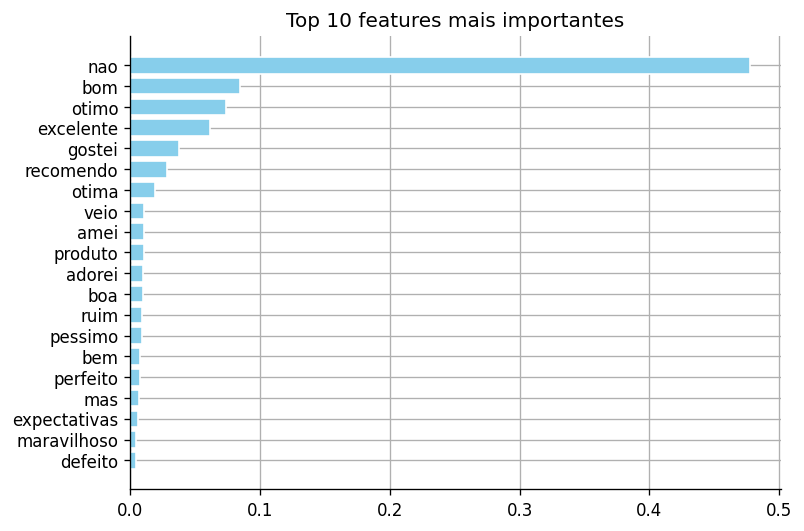

In [60]:
fig = plt.figure(figsize=(7, 5), dpi=120)
ax = fig.add_subplot(111)
plt.barh(*zip(*sorted_features[:20][::-1]), color='skyblue', edgecolor='w')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid()
plt.title('Top 10 features mais importantes')
plt.show()

* profundidade da árvore

In [61]:
sentiment_analyzer.named_steps['clf'].get_depth()

122

* note o parâmetro `max_depth=2`, que indica que vamos plotar apenas até o nível de profundidade 2 da árvore

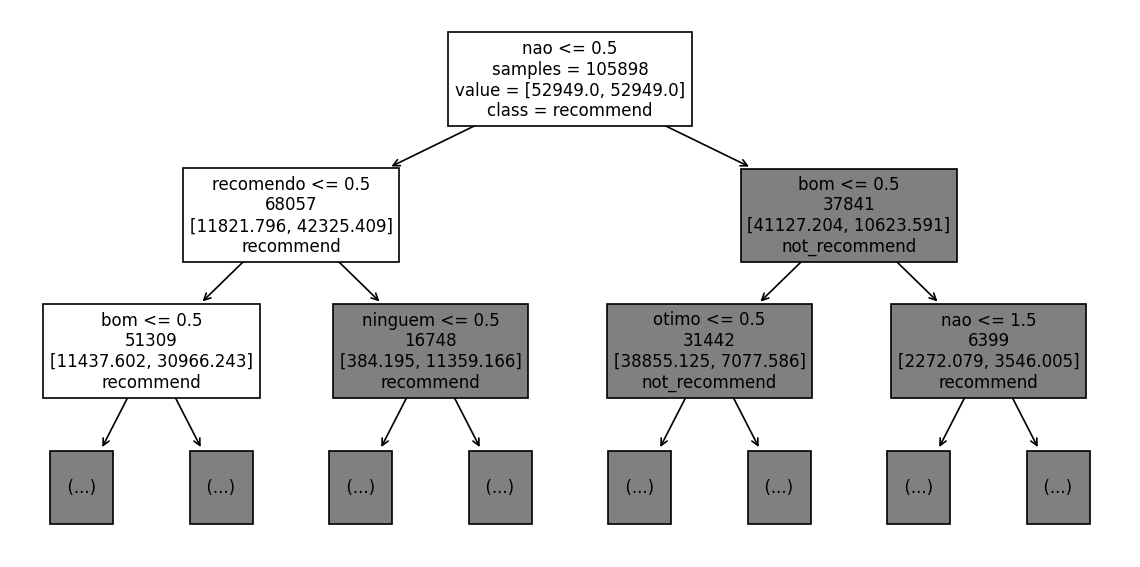

In [72]:
fig = plt.figure(figsize=(12, 6), dpi=120)
ax = fig.add_subplot(111)
_ = tree.plot_tree(sentiment_analyzer.named_steps['clf'], max_depth=2, label='root', proportion=False,
    impurity=False, feature_names=features, class_names=['not_recommend', 'recommend'], ax=ax, fontsize=10)

## Avaliação do classificador

**Tarefa:** Faça a predição da coluna `norm_text` e compare o resultado com o vetor target (coluna `y`).

1. crie a variável `X_test` (dica: veja como criamos a variável `X_train`. Deve ser a mesma coisa, utilizando agora o dataframe `test_df`)
2. crie a variável `y_test` (dica: veja como criamos a variável `y_train`. Deve ser a mesma coisa, utilizando agora o dataframe `test_df`)
3. crie a variável `y_pred` com as predições do modelo `sentiment_analyzer` em `X_train`
4. imprima o [classification_report](https://scikit-learn.org/0.19/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) usando como parâmetros `y_test`, `y_pred` e como `target_names` uma lista `['positive', 'negative']`.

<!-- 
X_test = test_df['norm_text'].values
y_test = test_df['y'].values
y_pred = sentiment_analyzer.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))
-->

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
X_test = test_df['norm_text'].values
y_test = test_df['target'].values

In [65]:
y_pred = sentiment_analyzer.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.75      0.89      0.81      7201
    positive       0.96      0.89      0.92     19274

    accuracy                           0.89     26475
   macro avg       0.85      0.89      0.87     26475
weighted avg       0.90      0.89      0.89     26475



#### Comparação com um classificador _naive_

Como exemplo de classificador _naive_, vamos criar um classificador que identifica como negativo os textos que contêm `nao` e positivo os textos que **não** contém `nao`

In [67]:
naive_pred = [int('nao' in text) for text in X_test]

In [68]:
print(classification_report(y_test, naive_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.09      0.22      0.13      7201
    positive       0.41      0.20      0.27     19274

    accuracy                           0.21     26475
   macro avg       0.25      0.21      0.20     26475
weighted avg       0.33      0.21      0.23     26475



### Matriz de confusão

|      | pred_0| pred_1|
|------|-------|-------|
|   0  |  TN   |  FP   |
|   1  |  FN   |  TP   |


Legenda:
* `TN`: verdadeiros negativos (predição está correta e o sentimento verdadeiro é negativo)
* `FP`: falsos positivos (predição está incorreta e o sentimento verdadeiro é negativo)
* `FN`: falsos negativos (predição está incorreta e o sentimento verdadeiro é positivo)
* `TP`: verdadeiros positivos (predição está correta e o sentimento verdadeiro é positivo)

In [69]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_0', 'pred_1'])

,pred_0,pred_1
0,6413,788
1,2164,17110


**Pergunta final:** O que você achou do classificador? Ele é bom ou ruim?